In [112]:
import os
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [74]:
dataset_path = '/kaggle/input/plantdisease/PlantVillage'
selected_classes = ['Pepper__bell___Bacterial_spot', 'Potato___Late_blight', 'Tomato_Late_blight']  

data = []
labels = []
# Iterate through the dataset directory
for class_name in os.listdir(dataset_path):
    if class_name in selected_classes:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append(img_path)
            labels.append(class_name)

df = pd.DataFrame({'data': data, 'label': labels})

In [75]:
df

,data,label
0,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
1,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
2,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
3,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
4,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
...,...,...
3901,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3902,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3903,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3904,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight


In [4]:
image = Image.open("/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG")
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 256, Height: 256


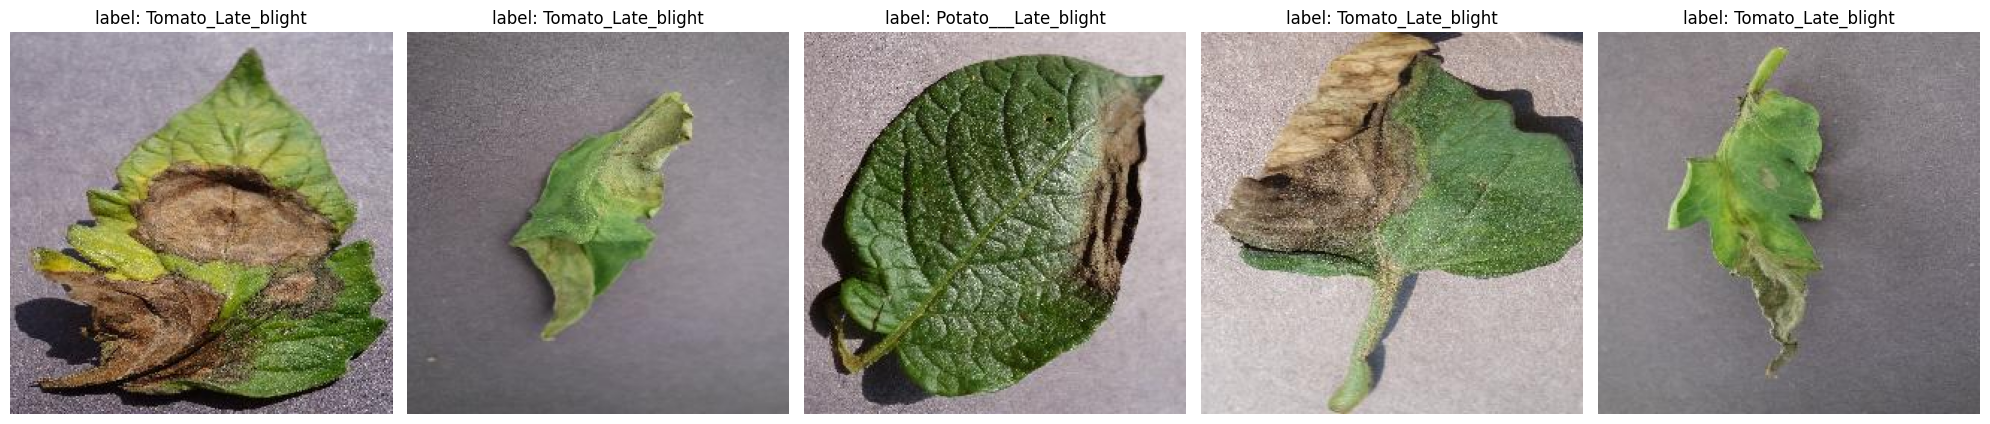

In [5]:
plt.figure(figsize=(20, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    index = np.random.choice(df.index)
    filename = df.loc[index, 'data']
    category = df.loc[index, 'label']
    img = Image.open(filename)
    plt.imshow(img)
    plt.title(f'label: {category}')
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [6]:
def extract_hog_features(image):
    # Convert the image to grayscale using cv2
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hog = cv2.HOGDescriptor()
    
    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features.flatten()

In [7]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
batch_size = 32  # Adjust batch size based on memory constraints
features_list = []
labels_list = []

# Resize function to downsample images
def resize_image(image, new_size=(128, 128)):
    return cv2.resize(image, new_size)

for start in range(0, len(df_shuffled), batch_size):
    end = min(start + batch_size, len(df_shuffled))
    batch = df_shuffled[start:end]

    batch_features = []
    batch_labels = []

    for index, row in batch.iterrows():
        image = cv2.imread(row['data'])
        resized_image = resize_image(image)  # Resize image to smaller dimensions
        hog_features = extract_hog_features(resized_image)
        batch_features.append(hog_features)
        batch_labels.append(row['label'])

    features_list.extend(batch_features)
    labels_list.extend(batch_labels)

Shape of extracted HOG features: (3906, 34020)


In [35]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

print("Shape of extracted HOG features:", features_scaled.shape)

Shape of extracted HOG features: (3906, 34020)


In [36]:
len(labels_encoded)

3906

In [37]:
np.unique(labels_encoded)

array([0, 1, 2])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_encoded, test_size=0.25, random_state=42 , stratify = labels_encoded)

In [39]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (2929, 34020)
<class 'numpy.ndarray'> (2929,)
<class 'numpy.ndarray'> (977, 34020)
<class 'numpy.ndarray'> (977,)


In [40]:
lr_pipeline = Pipeline([
    ('pca', PCA(n_components=2100,random_state=42)), 
    ('classifier', LogisticRegression(max_iter = 1000,random_state=42))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=2100, random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [41]:
predictions = lr_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8802


In [42]:
report = classification_report(y_test, predictions, output_dict=True,zero_division=1)

# Convert the report to a pandas DataFrame for better visualization
report = pd.DataFrame(report).transpose()

print(report)

              precision    recall  f1-score     support
0              0.902542  0.855422  0.878351  249.000000
1              0.853175  0.860000  0.856574  250.000000
2              0.883436  0.903766  0.893485  478.000000
accuracy       0.880246  0.880246  0.880246    0.880246
macro avg      0.879718  0.873062  0.876136  977.000000
weighted avg   0.880562  0.880246  0.880183  977.000000


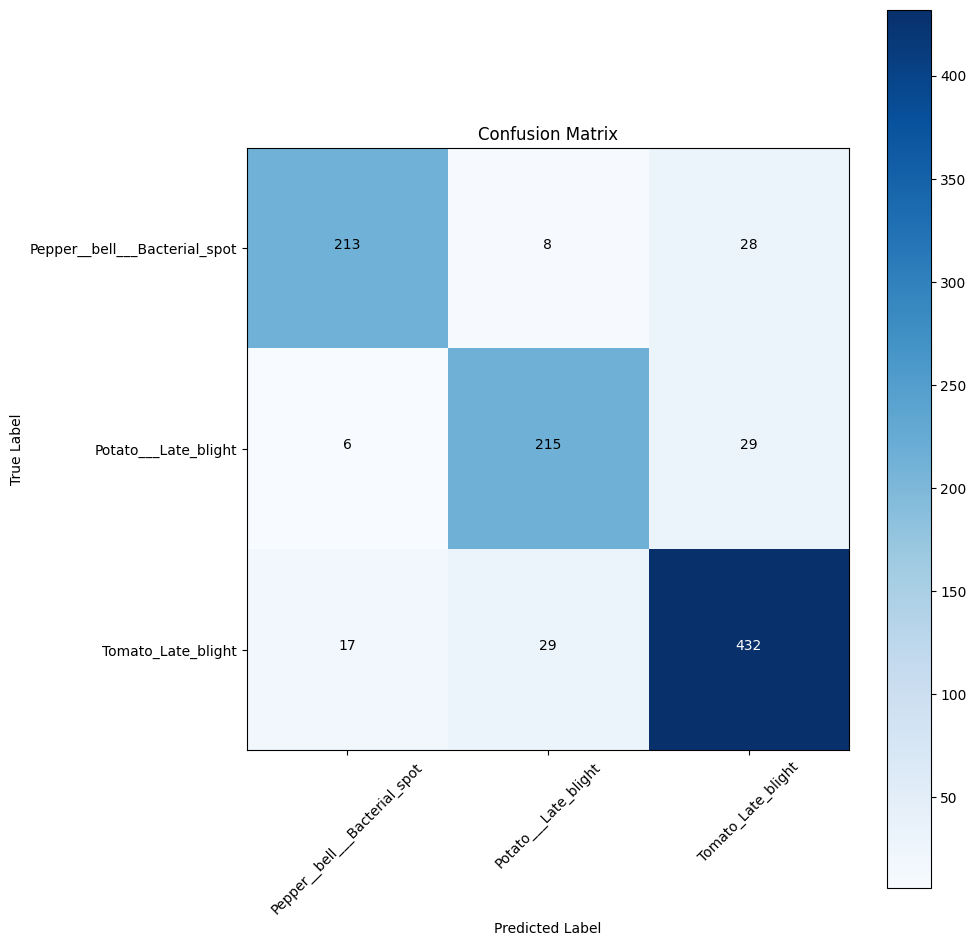

In [43]:
classes = selected_classes


cm = confusion_matrix(y_test, predictions)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.show()

### K-mean

In [22]:
df

,data,label
0,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
1,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
2,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
3,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
4,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
...,...,...
3901,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3902,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3903,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
3904,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight


In [76]:
images = [] 
for index2, row2 in df.iterrows():
        image = cv2.imread(row2['data'])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(gray_image)

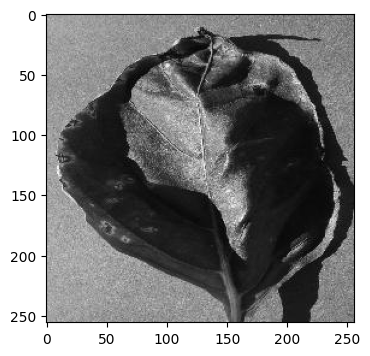

In [77]:
selected_image = images[0]

# Display the image using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(selected_image, cmap='gray')
plt.show()

In [78]:
print(gray_image.shape)

(256, 256)


In [79]:
images = np.array(images)

In [80]:
len(images)

3906

In [101]:
data = images.reshape((len(images), -1))

In [102]:
data.shape

(3906, 65536)

In [103]:
km = KMeans(n_clusters=3, random_state=42, n_init="auto")

In [106]:
km.fit_predict(data)

array([2, 2, 0, ..., 2, 0, 2], dtype=int32)

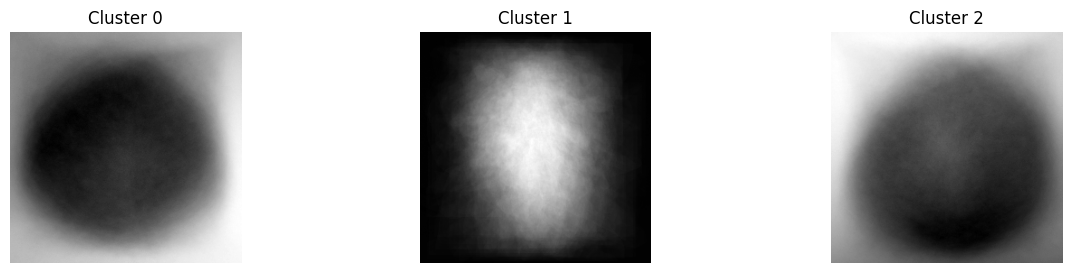

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for i in range(3):
    center_image = km.cluster_centers_[i].reshape(256, 256)  # Reshape to original dimensions
    ax[i].imshow(center_image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Cluster {i}')

plt.show()


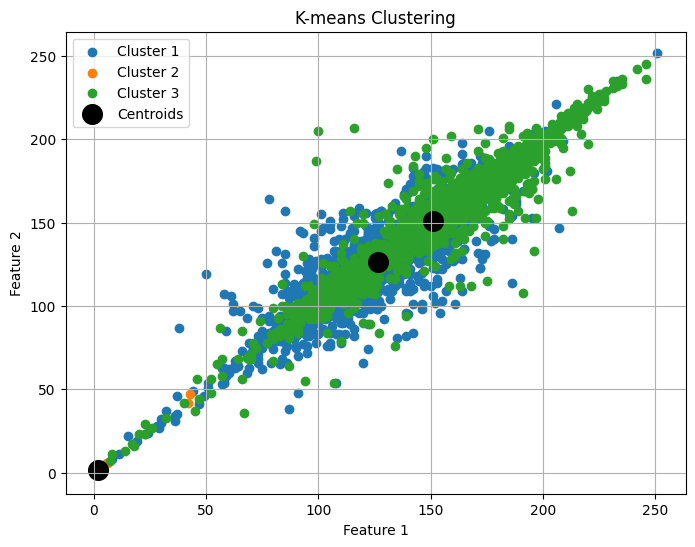

In [110]:
# Plotting the clustered data
plt.figure(figsize=(8, 6))
cluster_labels = km.labels_
# Scatter plot for each cluster
for cluster in range(3):
    plt.scatter(
        data[cluster_labels == cluster, 0],
        data[cluster_labels == cluster, 1],
        label=f'Cluster {cluster + 1}'
    )

# Plotting centroids if needed
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=200, color='black', label='Centroids')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()